# Introduction: 

# Setup: Import all necessary libraries

In [145]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Function definitions: 

In [ ]:
def get_NN12(rvid_query, df_interact):
    # first nearest neighbors: 
    df_NN1 = df_interact[(df_interact.lead_gene==rvid_query) | (df_interact.partner_gene==rvid_query)].copy()
    list_rvid_NN1 = list(set(df_NN1.lead_gene.tolist() + df_NN1.partner_gene.tolist()))
    list_rvid_NN1.sort()

    # second nearest neighbors: 
    df_NN2 = df_interact[ (df_interact.lead_gene.isin(list_rvid_NN1)) | (df_interact.partner_gene.isin(list_rvid_NN1))].copy()
    list_rvid_NN2 = list(set(df_NN2.lead_gene.tolist() + df_NN2.partner_gene.tolist()))
    list_rvid_NN2.sort()
    
#     # third nearest neighbors: 
#     df_NN3 = df_interact[ (df_interact.lead_gene.isin(list_rvid_NN2)) | (df_interact.partner_gene.isin(list_rvid_NN2))].copy()
#     list_rvid_NN3 = list(set(df_NN3.lead_gene.tolist() + df_NN3.partner_gene.tolist()))
#     list_rvid_NN3.sort()
    
    return list_rvid_NN1, list_rvid_NN2 #, list_rvid_NN3


def get_warped_screen_for_gene(gene_id, df, warped_screens):
    # Get the index of the gene in the DataFrame
    gene_index = df.index.get_loc(gene_id)
    
    # Extract the corresponding row from warped_screens
    gene_warped_screen = warped_screens[gene_index]

    return gene_warped_screen

def compute_gls_correlation(warped_gene1, warped_gene2, warped_interc):
    # Reshape the genes' data for linear regression
    X = np.stack((warped_interc, warped_gene1), axis=1)
    y = warped_gene2

    # Run linear regression
    coef, residues, _, _ = np.linalg.lstsq(X, y, rcond=None)
    df = len(warped_gene1) - 2  # degrees of freedom

    # Compute standard error
    GLS_se = np.sqrt(np.linalg.pinv(X.T @ X)[1, 1] * residues / df)
    
    # Return the GLS coefficient and standard error
    return coef[1], GLS_se


def loo_gls_correlation(warped_gene1, warped_gene2, warped_intercept):
    n = len(warped_gene1)
    loo_coefs = np.zeros(n)
    loo_se = np.zeros(n)

    for i in range(n):
        # Exclude the i-th screen
        loo_gene1 = np.delete(warped_gene1, i)
        loo_gene2 = np.delete(warped_gene2, i)
        loo_intercept = np.delete(warped_intercept, i)

        # Recompute the GLS correlation
        coef, se = compute_gls_correlation(loo_gene1, loo_gene2, loo_intercept)
        loo_coefs[i] = coef
        loo_se[i] = se

    return loo_coefs, loo_se


def analyze_loocv_results(loo_coefs, threshold=0.18):
    """
    Analyze the results of LOOCV to identify significant changes in GLS coefficients.
    
    Parameters:
    loo_coefs (array): Array of GLS coefficients from LOOCV.
    threshold (float): Threshold for considering a change in coefficient as significant.
    
    Returns:
    dict: A dictionary containing analysis results.
    """
    mean_coef = np.mean(loo_coefs)
    changes = loo_coefs - mean_coef
    # Determine worsening based on the sign of the mean coefficient
    if mean_coef > 0:
        # For positive correlations, worsening means becoming more negative
        significant_worsening = changes < -threshold
    else:
        # For negative correlations, worsening means becoming more positive
        significant_worsening = changes > threshold

    result = {
        "mean_coef": mean_coef,
        "changes": changes,
        "significant_worsening": significant_worsening,
        "num_significant_worsening": np.sum(significant_worsening),
        "is_robust": np.sum(significant_worsening) <= 1  # Robust if 1 or 0 significant changes
    }

    return result

def jaccard_similarity(set1, set2):
    intersection = len(set(set1).intersection(set2))
    union = len(set(set1).union(set2))
    return intersection / union


def find_subgraphs_containing_gene(gene, filtered_subgraphs):
    """
    Find all NN2 subgraphs that contain the specified gene.

    Parameters:
    gene (str): The gene (RvID) to search for.
    nn2_subgraphs (dict): A dictionary of NN2 subgraphs.

    Returns:
    dict: A dictionary of subgraphs that contain the specified gene.
    """
    subgraphs_containing_gene = {}
    for key, subgraph in filtered_subgraphs.items():
        if gene in subgraph:
            subgraphs_containing_gene[key] = subgraph
    return subgraphs_containing_gene


# Function to compute pairwise Jaccard similarities between subgraphs
def pairwise_jaccard_similarities(subgraphs_dict):
    keys = list(subgraphs_dict.keys())
    similarities = {}
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            gene_i, gene_j = keys[i], keys[j]
            sim = jaccard_similarity(subgraphs_dict[gene_i], subgraphs_dict[gene_j])
            if sim > 0:  # Only consider non-zero similarities
                similarities[(gene_i, gene_j)] = sim
    return similarities

# Load datasets: 

In [7]:
path_data = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/GLS_TnSeq_v2/'
fn_interact = 'test_SI_data_1_fdr.001.xlsx'
fn_interact_path = os.path.join(path_data, fn_interact)
df_interact = pd.read_excel(fn_interact_path)

# LFC dataset
fn_lfc = '../data/standardized_data/old_std_data/result_logfc_matrix_2021_11_15_BASIS_invitro.csv'
df_lfc = pd.read_csv(fn_lfc)
df_lfc.dropna(axis=0, inplace=True)

cols_data = df_lfc.columns[1:]

# Filter correlations driven by single outliers: 

In [8]:
df_lfc_gls = pd.read_csv(fn_lfc, index_col=0)
df_lfc_gls.dropna(axis=0, inplace=True)

mat_data = df_lfc_gls.values
cov_mat = np.cov(mat_data.T)
inv_mat = np.linalg.inv(cov_mat)

cholsigmainv = np.linalg.cholesky(inv_mat)
warped_screens = df_lfc_gls.values @ cholsigmainv
warped_intercept = cholsigmainv.sum(axis=0)

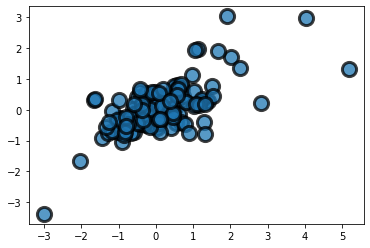

In [9]:
# These are two examples.
# Two scatter plots, one with and one without outliers. 
ind_outlier = 33
ind_robust = 330

ind = ind_robust
# RvID's of correlated genes. 
x_rvid = df_interact.iloc[ind]['lead_gene']
y_rvid = df_interact.iloc[ind]['partner_gene']
# GLS "warped" log2-fold changes
warped_gene_x = get_warped_screen_for_gene(x_rvid, df_lfc_gls, warped_screens)
warped_gene_y = get_warped_screen_for_gene(y_rvid, df_lfc_gls, warped_screens)

plt.scatter(warped_gene_x, warped_gene_y, s = 200, alpha = 0.75, edgecolors='k', linewidths=3)

In [13]:
# Assuming df_interact is your DataFrame with columns 'lead_gene' and 'partner_gene'
# Normalize the order of gene pairs
df_interact['sorted_gene_pair'] = df_interact.apply(lambda row: tuple(sorted([row['lead_gene'], row['partner_gene']])), axis=1)
# Identify duplicates based on the sorted gene pairs
duplicates = df_interact[df_interact.duplicated(subset='sorted_gene_pair', keep=False)]
# Drop duplicates based on the sorted gene pairs
df_interact = df_interact.drop_duplicates(subset='sorted_gene_pair')
# Optional: You might want to drop the 'sorted_gene_pair' column if it's no longer needed
# df_interact = df_interact.drop(columns=['sorted_gene_pair'])
print(df_interact.shape)
df_interact.head()

(5610, 4)


,lead_gene,partner_gene,p_value_FDR,sorted_gene_pair
0,Rv0001,Rv0062,1.962568e-04,"(Rv0001, Rv0062)"
1,Rv0001,Rv0283,4.421194e-09,"(Rv0001, Rv0283)"
2,Rv0001,Rv0415,6.310410e-09,"(Rv0001, Rv0415)"
3,Rv0001,Rv0537c,3.644942e-04,"(Rv0001, Rv0537c)"
4,Rv0001,Rv2247,2.852074e-07,"(Rv0001, Rv2247)"


In [14]:
gene_pairs = [(row.lead_gene, row.partner_gene) for row in df_interact.itertuples()]
len(gene_pairs)

5610

In [15]:
# Assuming you have the functions defined for LOOCV and analysis
results_df = pd.DataFrame(columns=['gene_pair', 'mean_coef', 'min_change', 'max_change', 'num_significant_worsening'])

for gene1, gene2 in tqdm(gene_pairs):  # First 100 gene pairs
    warped_gene_x = get_warped_screen_for_gene(gene1, df_lfc_gls, warped_screens)
    warped_gene_y = get_warped_screen_for_gene(gene2, df_lfc_gls, warped_screens)

    loo_coefs, loo_se = loo_gls_correlation(warped_gene_x, warped_gene_y, warped_intercept)
    result = analyze_loocv_results(loo_coefs)
    
    # Create a new DataFrame for the current result
    new_result_df = pd.DataFrame([{
        'gene_pair': (gene1, gene2),
        'mean_coef': result['mean_coef'],
        'min_change': np.min(result['changes']),
        'max_change': np.max(result['changes']),
        'num_significant_worsening': result['num_significant_worsening']
    }])
    
    # Concatenate with the main DataFrame
    results_df = pd.concat([results_df, new_result_df], ignore_index=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 5610/5610 [01:50<00:00, 50.73it/s]


In [16]:
gp_str = ['_'.join([gp[0], gp[1]]) for gp in results_df.gene_pair]
results_df['gene_pair_str'] = gp_str

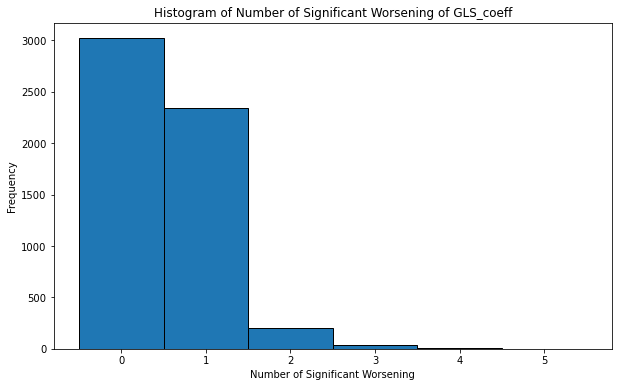

In [17]:
# Assuming results_df is your DataFrame and it contains 'num_significant_changes' column
num_significant_worsening = results_df['num_significant_worsening']
# Determine the maximum number for setting bin edges
max_num = int(num_significant_worsening.max())
# Create bin edges aligned with integers
bins = [i - 0.5 for i in range(max_num + 2)]

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(num_significant_worsening, bins=bins, edgecolor='black')

# Setting the x-axis to show integer values
plt.xticks(range(max_num + 1))

plt.xlabel('Number of Significant Worsening')
plt.ylabel('Frequency')
ttl = plt.title('Histogram of Number of Significant Worsening of GLS_coeff')

('Rv0561c', 'Rv3283')
('Rv1091', 'Rv3514')
('Rv1307', 'Rv2980')


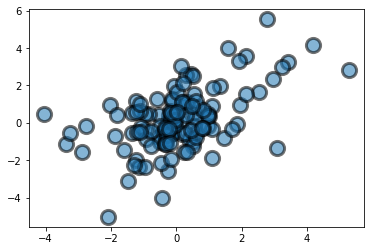

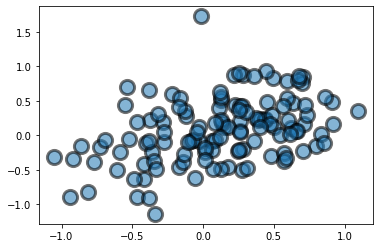

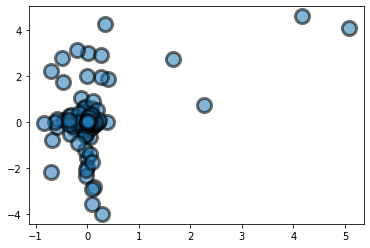

In [18]:
sample_pairs = results_df[results_df.num_significant_worsening == 0].gene_pair.sample(3).tolist()
for gp in sample_pairs:
    print(gp)
    # GLS "warped" log2-fold changes
    warped_gene_x = get_warped_screen_for_gene(gp[0], df_lfc_gls, warped_screens)
    warped_gene_y = get_warped_screen_for_gene(gp[1], df_lfc_gls, warped_screens)
    plt.figure()
    plt.scatter(warped_gene_x, warped_gene_y, s = 200, alpha = 0.55, edgecolors='k', linewidths=3)

In [19]:
results_df[results_df.gene_pair_str.str.contains('Rv2733c')]

,gene_pair,mean_coef,min_change,max_change,num_significant_worsening,gene_pair_str
3281,"(Rv1493, Rv2733c)",0.604711,-0.063511,0.042608,0,Rv1493_Rv2733c


In [20]:
# Assuming results_df contains 'max_deviation' column
max_change = results_df['max_change']

# Basic statistical summaries
print(max_change.describe())


count    5610.000000
mean        0.197921
std         0.611191
min         0.001244
25%         0.039049
50%         0.081945
75%         0.198015
max        22.720814
Name: max_change, dtype: float64


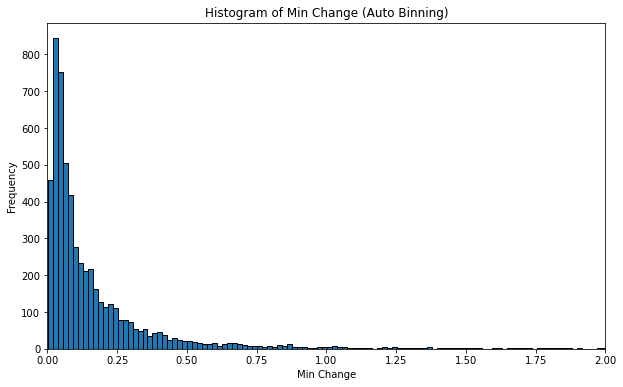

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(max_change, bins='auto', edgecolor='black')
plt.xlim(0,2)
plt.xlabel('Min Change')
plt.ylabel('Frequency')
ttl = plt.title('Histogram of Min Change (Auto Binning)')

In [24]:
# Find the row(s) with the maximum deviation
extreme_cases = results_df[results_df['max_change'] == results_df['max_change'].max()]
print(extreme_cases)

               gene_pair  mean_coef  min_change  max_change  \
4121  (Rv2158c, Rv3193c) -22.947635   -5.533442   22.720814   

     num_significant_worsening    gene_pair_str  
4121                         4  Rv2158c_Rv3193c  


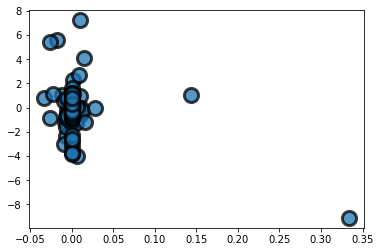

In [25]:
gp = extreme_cases.gene_pair.values[0]
# GLS "warped" log2-fold changes
warped_gene_x = get_warped_screen_for_gene(gp[0], df_lfc_gls, warped_screens)
warped_gene_y = get_warped_screen_for_gene(gp[1], df_lfc_gls, warped_screens)
plt.figure()
plt.scatter(warped_gene_x, warped_gene_y, s = 200, alpha = 0.75, edgecolors='k', linewidths=3)

# Find the *unique* set of "modules" or NN2-based subgraphs.

In [26]:
results_df_filt = results_df[results_df.num_significant_worsening != 1]
results_df_filt.shape

(3268, 6)

In [32]:
df_interact_filt = df_interact[df_interact.sorted_gene_pair.isin(results_df_filt.gene_pair)].copy()
list_pairs = df_interact.sorted_gene_pair.tolist()

In [33]:
df_interact.shape, df_interact_filt.shape

((5610, 4), (3268, 4))

In [34]:
# Get set of unique genes: 
list_gene_1 = [gp[0] for gp in list_pairs]
list_gene_2 = [gp[1] for gp in list_pairs]
list_unique_genes = list(set( list_gene_1 + list_gene_2 ))
len(list_unique_genes)

1249

In [69]:
nn2_subgraphs = {}
for gene in tqdm(list_unique_genes):
    list_rvid_NN1, list_rvid_NN2 = get_NN12(gene, df_interact)
    subgraph = set(list_rvid_NN2)
    subgraph.add(gene)
    nn2_subgraphs[gene] = subgraph 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1249/1249 [00:02<00:00, 515.73it/s]


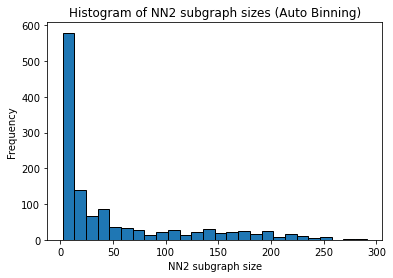

In [70]:
len_NN2 = np.array([len(val) for val in nn2_subgraphs.values()])
hst = plt.hist(len_NN2, bins='auto', edgecolor='black')
plt.xlabel('NN2 subgraph size')
plt.ylabel('Frequency')
ttl = plt.title('Histogram of NN2 subgraph sizes (Auto Binning)')

In [136]:
# Threshold for filtering similar subgraphs
similarity_threshold = 0.25  # Adjust as needed

filtered_subgraphs = {}
for gene, subgraph in tqdm(nn2_subgraphs.items()):
    is_unique = True  # Assume the subgraph is unique initially
    
    # Compare with already filtered subgraphs
    for existing_subgraph in filtered_subgraphs.values():
        if jaccard_similarity(subgraph, existing_subgraph) >= similarity_threshold:
            is_unique = False
            break  # If similar to an existing subgraph, it's not unique

    # If the subgraph is unique, add it to the filtered subgraphs
    if is_unique:
        filtered_subgraphs[gene] = subgraph


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1249/1249 [00:00<00:00, 6892.45it/s]


In [137]:
len(nn2_subgraphs), len(filtered_subgraphs)

(1249, 254)

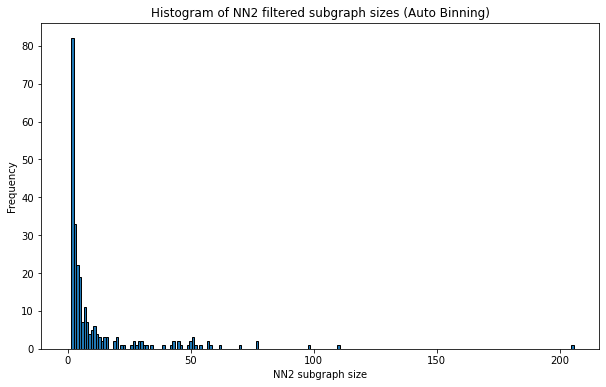

In [138]:
len_NN2 = np.array([len(val) for val in filtered_subgraphs.values()])
# Determine the range for your bins
max_size = len_NN2.max()
bins = np.arange(0, max_size + 2) - 0.5  # Bin edges aligned with integers

# Plotting the histogram
plt.figure(figsize=(10, 6))
hst = plt.hist(len_NN2, bins=bins, edgecolor='black')
plt.xlabel('NN2 subgraph size')
plt.ylabel('Frequency')
ttl = plt.title('Histogram of NN2 filtered subgraph sizes (Auto Binning)')

In [140]:
# Example usage
gene_to_search = "Rv0101"  # Replace with the actual gene RvID
subgraphs_with_gene = find_subgraphs_containing_gene(gene_to_search, filtered_subgraphs)

# Display the results
for key, subgraph in subgraphs_with_gene.items():
    print(f"The NN2 subgraph generated from using **{key}** as the seed gene contains **{gene_to_search}**.\nHere is the full subgraph: {sorted(subgraph)}")

The NN2 subgraph generated from using **Rv0097** as the seed gene contains **Rv0101**.
Here is the full subgraph: ['Rv0096', 'Rv0097', 'Rv0098', 'Rv0099', 'Rv0101', 'Rv0199', 'Rv2069']


## Analyze what's up with the large subgraphs? 

In [141]:
# Define a size threshold for large subgraphs, this could be based on your histogram analysis
size_threshold = 20  # for example, subgraphs with size > 10

# Get a list of large subgraphs
large_subgraphs = {gene: subgraph for gene, subgraph in filtered_subgraphs.items() if len(subgraph) > size_threshold}

len(large_subgraphs)

38

In [144]:


# Compute similarities between large subgraphs
large_subgraph_similarities = pairwise_jaccard_similarities(large_subgraphs)

# Sort by similarity score to see the most similar large subgraphs
sorted_similarities = sorted(large_subgraph_similarities.items(), key=lambda item: item[1], reverse=True)

# Print some of the most similar large subgraphs
for pair, sim in sorted_similarities[:10]:  # Top 10 most similar pairs
    print(f"Genes: {pair}, Jaccard Similarity: {sim}")


Genes: ('Rv3227', 'Rv0422c'), Jaccard Similarity: 0.2459016393442623
Genes: ('Rv1652', 'Rv0236A'), Jaccard Similarity: 0.2450592885375494
Genes: ('Rv0708', 'Rv3227'), Jaccard Similarity: 0.2413793103448276
Genes: ('Rv1342c', 'Rv3443c'), Jaccard Similarity: 0.24096385542168675
Genes: ('Rv0236A', 'Rv0334'), Jaccard Similarity: 0.23841059602649006
Genes: ('Rv2413c', 'Rv0538'), Jaccard Similarity: 0.23728813559322035
Genes: ('Rv1437', 'Rv2235'), Jaccard Similarity: 0.23214285714285715
Genes: ('Rv2393', 'Rv0334'), Jaccard Similarity: 0.232
Genes: ('Rv2393', 'Rv2235'), Jaccard Similarity: 0.22988505747126436
Genes: ('Rv2357c', 'Rv2050'), Jaccard Similarity: 0.22988505747126436


SyntaxError: unexpected EOF while parsing (3252940444.py, line 15)

# How many are of size 2? 
# How many are manageable / intermediate size? 